In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_gaussian_quantiles

### SVM vs. RF on Gaussian


In [2]:
# Generate dataset with Gaussian quantiles 
X, y = make_gaussian_quantiles(n_samples=1000, 
                                n_features=2, 
                                n_classes=2,
                                random_state=808,
                                cov=3.0) # throwing noise in there for the model. Gives us overfitting potential to play with. Covariance matrix. 

# Introduce additional noise by flipping some labels (0s,1s)
# Boolean mask, flip 10% of the labels from 0 case to 1 case. (neg to positive). Introduced noise by swtiching labels around
flip_mask = np.random.rand(len(y)) < 0.15 # 15% of the labels will be flipped
y[flip_mask] = 1 -y[flip_mask] # 1 minus the values of the one's we're flipping. 1-1 = 0, 1-0 = 1

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=808)

In [10]:
# Set up SVM with RBF kernel and hyperparameter tuning and fit
param_grid_svm = {
    'C':np.logspace(-2,2,10), # 10^-2 and 10^2 10 values in between
}
grid_search_svm = GridSearchCV(SVC(kernel='rbf', random_state=808), param_grid_svm, cv=5)
grid_search_svm.fit(X_train, y_train)

# Best SVM model
best_svm = grid_search_svm.best_estimator_
y_train_pred_svm = best_svm.predict(X_train) # now that we have the best one, train on the full dataset rather than 4/5 of the dataset (cv)
y_test_pred_svm = best_svm.predict(X_test)


In [13]:
# Train a Random Forest model with hyperparameter tuning and fit
param_grid_rf = {
    'n_estimators': [10, 50, 100, 2000],
    'max_depth': [2, 5, 10, None]
    }
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=808), param_grid_rf, cv=5)
grid_search_rf.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=808),
             param_grid={'max_depth': [2, 5, 10, None],
                         'n_estimators': [10, 50, 100, 2000]})

In [14]:
# Best RF model
best_rf = grid_search_rf.best_estimator_
y_train_pred_rf = best_rf.predict(X_train)
y_test_pred_rf = best_rf.predict(X_test)

In [ ]:
# Compute accuracy for both models
train_acc_svm = accuracy_score(y_train, y_train_pred_svm)
test_acc_svm = accuracy_score(y_test, y_test_pred_svm)

train_acc_rf = accuracy_score(y_train, y_train_pred_rf)
test_acc_rf = accuracy_score(y_test, y_test_pred_rf)

print(f"SVM Train Accuracy: {train_acc_svm:.2f}, Test Accuracy: {test_acc_svm:.2f}")
print(f"RF Train Accuracy: {train_acc_rf:.2f}, Test Accuracy: {test_acc_rf:.2f}")


SVM Train Accuracy: 0.83, Test Accuracy: 0.82
RF Train Accuracy: 0.83, Test Accuracy: 0.78


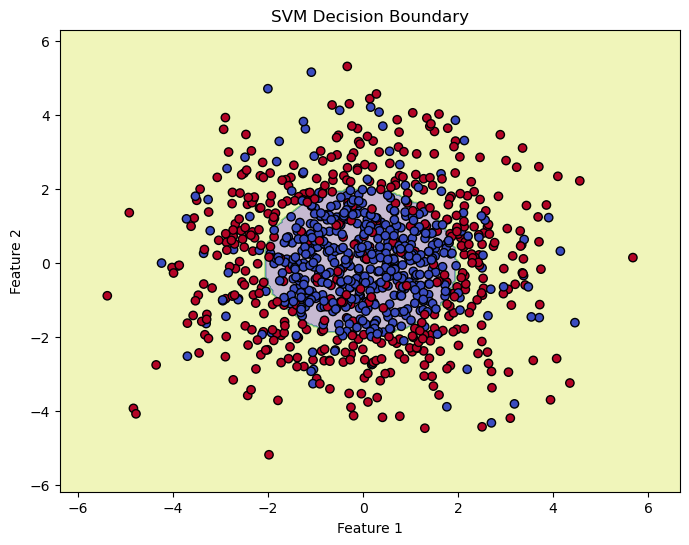

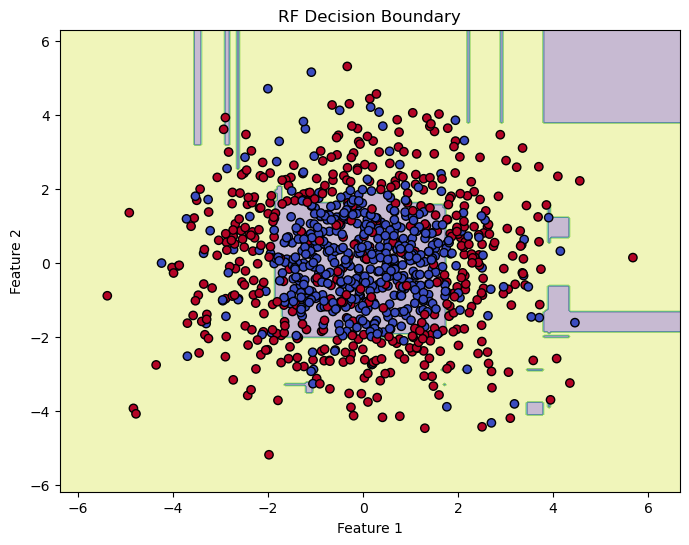

In [22]:
# Function to visualize decision boundaries
def plot_decision_boundary(model, X, y, title):
    h = 0.05  # Step size in the mesh
    
    # Define the range for plotting based on feature values
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1 
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # Create a meshgrid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict the class for each point in the grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Reshape predictions to match the grid shape for contour plotting
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', cmap=plt.cm.coolwarm)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(title)
    plt.show()

# Visualize decision boundaries
plot_decision_boundary(best_svm, X, y, "SVM Decision Boundary")
plot_decision_boundary(best_rf, X, y, "RF Decision Boundary")

### Effect of C parameter on overfitting

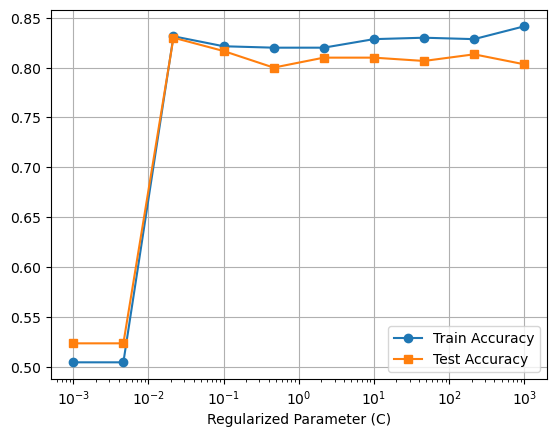

In [26]:
# Test different values of C in SVM with an RBF kernel
C_values = np.logspace(-3, 3, 10) # support vectors, values that fall close to the decision boundary
train_scores_svm = []
test_scores_svm = []

# Fit a series of SVM, varying C
# How does C affect overfitting?
for C in C_values:
    svm = SVC(kernel='rbf', random_state=808, C=C) # hold kernel constant
    svm.fit(X_train, y_train)

    # Compute train and test accuracy
    train_scores_svm.append(accuracy_score(y_train, svm.predict(X_train)))
    test_scores_svm.append(accuracy_score(y_test, svm.predict(X_test)))

# Plot Learning Curve: Training vs. Test Accuracy
plt.plot(C_values, train_scores_svm, marker='o', label='Train Accuracy')
plt.plot(C_values, test_scores_svm, marker='s', label='Test Accuracy')
plt.xscale("log")
plt.xlabel('Regularized Parameter (C)')
plt.legend()
plt.grid(True)
plt.show()


As you crank up C very high, you start to overfit (modest overfitting compared to RF, but still). Robust model to different parameters.